# Predicting Fraud with Autoencorders with Keras

Train an autoencoder to detect credit card fraud

The input variables consist of only numerical values which are the result of a PCA transformation. The features V1, …, V28 were obtained with PCA. There are however 2 features (Time and Amount) that were not transformed. Time is the seconds elapsed between each transaction and the first transaction in the dataset. Amount is the transaction amount and could be used for cost-sensitive learning. The Class variable takes value 1 in case of fraud and 0 otherwise.

Source:
- https://tensorflow.rstudio.com/blog/keras-fraud-autoencoder.html
- https://libraries.io/github/clintonreece/keras-cloud-ml-engine
- https://cloud.google.com/ml-engine/docs/tutorials
- http://projects.rajivshah.com/blog/2017/01/24/openai_mod/
- http://projects.rajivshah.com/blog/2017/06/04/deeplearningR/
- https://tensorflow.rstudio.com/categories/keras.html
- https://tensorflow.rstudio.com/categories/examples.html
- https://tensorflow.rstudio.com/categories/estimators.html

Additional resources:
- https://tensorflow.rstudio.com/tools/training_flags.html
- https://tensorflow.rstudio.com/tools/cloudml/articles/tuning.html
- https://cloud.google.com/ml-engine/reference/rest/v1/projects.jobs#HyperparameterSpec
- https://keras.rstudio.com/articles/faq.html
- https://keras.rstudio.com/articles/functional_api.html
- https://keras.rstudio.com/articles/sequential_model.html
- https://keras.rstudio.com/articles/training_visualization.html
- https://github.com/rajshah4/image_keras
- http://htmlpreview.github.io/?https://github.com/rajshah4/image_keras/blob/master/Rnotebook.nb.html
- https://github.com/rajshah4/image_keras/blob/master/Rnotebook.Rmd

Python:
- https://github.com/rajshah4/image_keras/blob/master/notebook.ipynb
- https://github.com/rajshah4/image_keras/blob/master/notebook_extras.ipynb

In [1]:
# Load libraries
library(readr)
library(tidyr)
library(dplyr)
library(ggplot2)
library(ggridges)
library(purrr)
library(Metrics)
library(pROC)
library(tensorflow)
library(keras)

keras:::keras_version() # ‘2.1.3’
tensorflow::tf_config() # v1.4.1


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following object is masked from ‘package:Metrics’:

    auc

The following objects are masked from ‘package:stats’:

    cov, smooth, var



[1] ‘2.1.3’

TensorFlow v1.4.1 (~/Library/Python/2.7/lib/python/site-packages/keras)
Python v2.7 (/Library/Frameworks/Python.framework/Versions/2.7/bin/python)

In [2]:
# Load data
df <- read_csv('creditcard.csv', col_types = list(Time = col_number()))

In [3]:
# Return the first part of the dataset
head(df)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,⋯,-0.018306778,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0
0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,⋯,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0
1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,⋯,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0
1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,⋯,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0
2,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,⋯,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0
2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,⋯,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0


In [4]:
# Pull up a summary of the dataset
summary(df)

      Time              V1                  V2                  V3          
 Min.   :     0   Min.   :-56.40751   Min.   :-72.71573   Min.   :-48.3256  
 1st Qu.: 54201   1st Qu.: -0.92037   1st Qu.: -0.59855   1st Qu.: -0.8904  
 Median : 84691   Median :  0.01811   Median :  0.06549   Median :  0.1799  
 Mean   : 94814   Mean   :  0.00000   Mean   :  0.00000   Mean   :  0.0000  
 3rd Qu.:139320   3rd Qu.:  1.31564   3rd Qu.:  0.80372   3rd Qu.:  1.0272  
 Max.   :172792   Max.   :  2.45493   Max.   : 22.05773   Max.   :  9.3826  
       V4                 V5                   V6                 V7          
 Min.   :-5.68317   Min.   :-113.74331   Min.   :-26.1605   Min.   :-43.5572  
 1st Qu.:-0.84864   1st Qu.:  -0.69160   1st Qu.: -0.7683   1st Qu.: -0.5541  
 Median :-0.01985   Median :  -0.05434   Median : -0.2742   Median :  0.0401  
 Mean   : 0.00000   Mean   :   0.00000   Mean   :  0.0000   Mean   :  0.0000  
 3rd Qu.: 0.74334   3rd Qu.:   0.61193   3rd Qu.:  0.3986   3rd Qu

Since only 0.001728 (i.e. Mean) of the observation are frauds, we have a highly unbalanced classification problem. 

An autoencoder is a neural network that is used to learn a representation (encoding) for a set of data, typically the purpose of dimensionality reduction. we will train an autoencoder to encode non-fraud observations from our training set. Since frauds are supposed to have a different distribution then normal transactions, we expect that our autoencoder will have higher reconstruction errors on frauds then on normal transactions. This means that we can use the reconstruction error as a quantity that indicates if a transaction is fraudulent or not.

## Visualization
For an autoencoder to work well we have a strong initial assumption: that the distribution of variables for normal transactions is different from the distribution for fraudulent ones. Let’s make some plots to verify this. Variables were transformed to a [0,1] interval for plotting.

Picking joint bandwidth of 0.0309


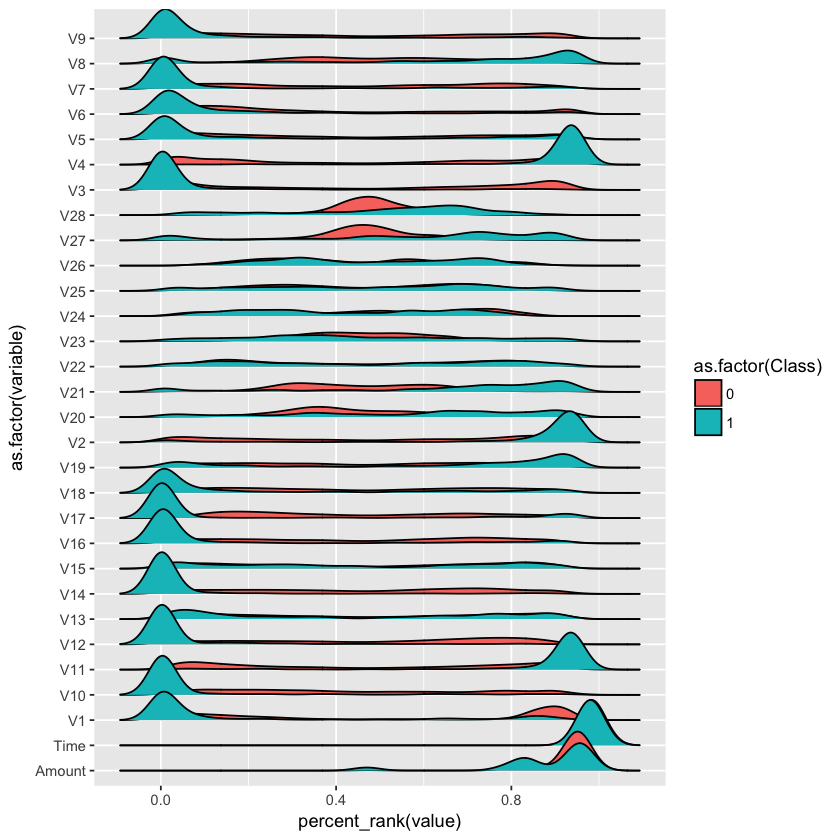

In [5]:
df %>%
  gather(variable, value, -Class) %>%
  ggplot(aes(y = as.factor(variable), 
             fill = as.factor(Class), 
             x = percent_rank(value))) +
  geom_density_ridges()

We can see that distributions of variables for fraudulent transactions are very different then from normal ones, except for the Time variable, which seems to have the exact same distribution.

## Preprocessing

Before the modeling steps we need to do some preprocessing. We will split the dataset into train and test sets and then we will Min-max normalize our data (this is done because neural networks work much better with small input values). We will also remove the Time variable as it has the exact same distribution for normal and fraudulent transactions.

Based on the Time variable we will use the first 200,000 observations for training and the rest for testing. This is good practice because when using the model we want to predict future frauds based on transactions that happened before.

In [6]:
df_train <- df %>% filter(row_number(Time) <= 200000) %>% select(-Time)
df_test <- df %>% filter(row_number(Time) > 200000) %>% select(-Time)

Now let’s work on normalization of inputs. We created 2 functions to help us. The first one gets descriptive statistics about the dataset that are used for scaling. Then we have a function to perform the min-max scaling. It’s important to note that we applied the same normalization constants for training and test sets.

In [7]:
# Gets descriptive statistics for every variable in the dataset.
get_desc <- function(x) {
    map(x, ~list(
        min = min(.x),
        max = max(.x),
        mean = mean(.x),
        sd = sd(.x)
    ))
}

In [8]:
# Given a dataset and normalization constants it will create a min-max  normalization version of the dataset
normalization_minmax <- function(x, desc) {
    map2_dfc(x, desc, ~(.x - .y$min)/(.y$max - .y$min))
}

Now let’s create normalized versions of our datasets. We also transformed our data frames to matrices since this is the format expected by Keras.

In [9]:
# Statistical description
desc <- df_train %>% 
  select(-Class) %>% 
  get_desc()

In [10]:
# Min-max normalize 
x_train <- df_train %>%
  select(-Class) %>%
  normalization_minmax(desc) %>%
  as.matrix()

In [11]:
# Min-max normalize 
x_test <- df_test %>%
  select(-Class) %>%
  normalization_minmax(desc) %>%
  as.matrix()

In [12]:
#y_train <- df_train$Class
#y_test <- df_test$Class

In [13]:
y_train <- df_train %>%
  select(Class) %>%
  as.matrix()

In [14]:
y_test <- df_test %>%
  select(Class) %>%
  as.matrix()

In [15]:
head(x_train)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0.9351923,0.7664904,0.8410207,0.3130227,0.5433374,0.5467858,0.5458604,0.7864442,0.4753117,0.5106005,⋯,0.3940668,0.5611844,0.5229921,0.7004668,0.4232900,0.5851218,0.3945568,0.6538160,0.2565886,0.0076117199
0.9785420,0.7700667,0.7859888,0.2717965,0.5485140,0.5355977,0.5418920,0.7862984,0.4539810,0.5052673,⋯,0.3891089,0.5578399,0.4802370,0.7037854,0.3639891,0.5872903,0.4460130,0.6497104,0.2573739,0.0001368502
0.9352170,0.7531177,0.8232995,0.2687655,0.5411948,0.5742682,0.5527385,0.7880423,0.4106027,0.5130180,⋯,0.3982987,0.5654773,0.5460298,0.7164498,0.3130473,0.5595152,0.4027272,0.6483747,0.2557391,0.0192638273
0.9418780,0.7653040,0.8237589,0.2136612,0.5476001,0.5629045,0.5458356,0.7894342,0.4149994,0.5075850,⋯,0.3869593,0.5597337,0.5102770,0.6992155,0.2421537,0.6142454,0.3891967,0.6517757,0.2583997,0.0062828994
0.9386168,0.7765198,0.8180865,0.2697964,0.5424424,0.5392592,0.5502643,0.7824835,0.4909496,0.5243028,⋯,0.3964975,0.5613275,0.5472707,0.7000439,0.4341274,0.5663427,0.5074968,0.6562892,0.2617732,0.0035606488
0.9510571,0.7773933,0.8086212,0.2444717,0.5532050,0.5366786,0.5488093,0.7881778,0.4431902,0.5010377,⋯,0.3914920,0.5581224,0.4839152,0.7017844,0.3593852,0.5648393,0.4427493,0.6572807,0.2588304,0.0001867064


Model definition

We will now define our model in keras, a symmetric autoencoder with 4 dense layers

### Define neural network architecture

In [16]:
# Fit the model to the data
model <- keras_model_sequential()

# Add layers to model
model %>%
  layer_dense(units = 15, activation = "relu", # "tanh"
              input_shape = ncol(x_train)
             ) %>%
  layer_dense(units = 10, 
              activation = "relu" # "tanh"
             ) %>%
  layer_dense(units = 15, 
              activation = "relu" # "tanh"
             ) %>%
  layer_dense(units = ncol(y_train))

In [17]:
# Print a summary of a model
summary(model)

# Get model configuration
get_config(model)

# Get layer configuration
get_layer(model, index = 1)

# List the model's layers
model$layers

# List the input tensors
model$inputs

# List the output tensors
model$outputs

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 15)                      450         
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      160         
________________________________________________________________________________
dense_3 (Dense)                     (None, 15)                      165         
________________________________________________________________________________
dense_4 (Dense)                     (None, 1)                       16          
Total params: 791
Trainable params: 791
Non-trainable params: 0
________________________________________________________________________________


[{'class_name': 'Dense', 'config': {'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'distribution': 'uniform', 'scale': 1.0, 'seed': None, 'mode': 'fan_avg'}}, 'name': 'dense_1', 'kernel_constraint': None, 'bias_regularizer': None, 'bias_constraint': None, 'dtype': 'float32', 'activation': 'relu', 'trainable': True, 'kernel_regularizer': None, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'units': 15, 'batch_input_shape': (None, 29), 'use_bias': True, 'activity_regularizer': None}}, {'class_name': 'Dense', 'config': {'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'distribution': 'uniform', 'scale': 1.0, 'seed': None, 'mode': 'fan_avg'}}, 'name': 'dense_2', 'kernel_constraint': None, 'bias_regularizer': None, 'bias_constraint': None, 'activation': 'relu', 'trainable': True, 'kernel_regularizer': None, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'units': 10, 'use_bias': True, 'activity_regularizer': None}}, {'class_name':

<keras.layers.core.Dense>

[[1]]
<keras.layers.core.Dense>

[[2]]
<keras.layers.core.Dense>

[[3]]
<keras.layers.core.Dense>

[[4]]
<keras.layers.core.Dense>


[[1]]
Tensor("dense_1_input:0", shape=(?, 29), dtype=float32)


[[1]]
Tensor("dense_4/BiasAdd:0", shape=(?, 1), dtype=float32)


We will then compile our model, using the mean squared error loss and the Adam optimizer for training.

In [18]:
# Compile the model
model %>% compile(
    loss = "mean_squared_error", 
    optimizer = "adam",
    metrics='acc'
)

Training the model

We can now train our model using the fit() function. Training the model is reasonably fast (~ 14s per epoch on my laptop). We will only feed to our model the observations of normal (non-fraudulent) transactions.

We will use callback_model_checkpoint() in order to save our model after each epoch. By passing the argument save_best_only = TRUE we will keep on disk only the epoch with smallest loss value on the test set. We will also use callback_early_stopping() to stop training if the validation loss stops decreasing for 5 epochs.

In [19]:
# Check point
checkpoint <- callback_model_checkpoint(
  filepath = "model.hdf5", 
  save_best_only = TRUE, 
  period = 1,
  verbose = 2
)

In [20]:
# Early stopping
early_stopping <- callback_early_stopping(patience = 5)

In [31]:
# Launch TensorBoard (data won't show up until after the first epoch)
#tensorboard("logs/run_a")

In [23]:
# Fit the model to the data and store the training fit history in `history` with the TensorBoard callback 
history <- model %>% fit(
    x = x_train, 
    y = y_train,
    epochs = 30, 
    batch_size = 128,
    validation_split = 0.2,
    callbacks = list(checkpoint, early_stopping, callback_tensorboard("logs/run_a"))
)

In [24]:
history_df <- as.data.frame(history)
str(history_df)

'data.frame':	120 obs. of  4 variables:
 $ epoch : int  1 2 3 4 5 6 7 8 9 10 ...
 $ value : num  0.998 0.999 0.999 0.999 0.999 ...
 $ metric: Factor w/ 2 levels "acc","loss": 1 1 1 1 1 1 1 1 1 1 ...
 $ data  : Factor w/ 2 levels "training","validation": 1 1 1 1 1 1 1 1 1 1 ...


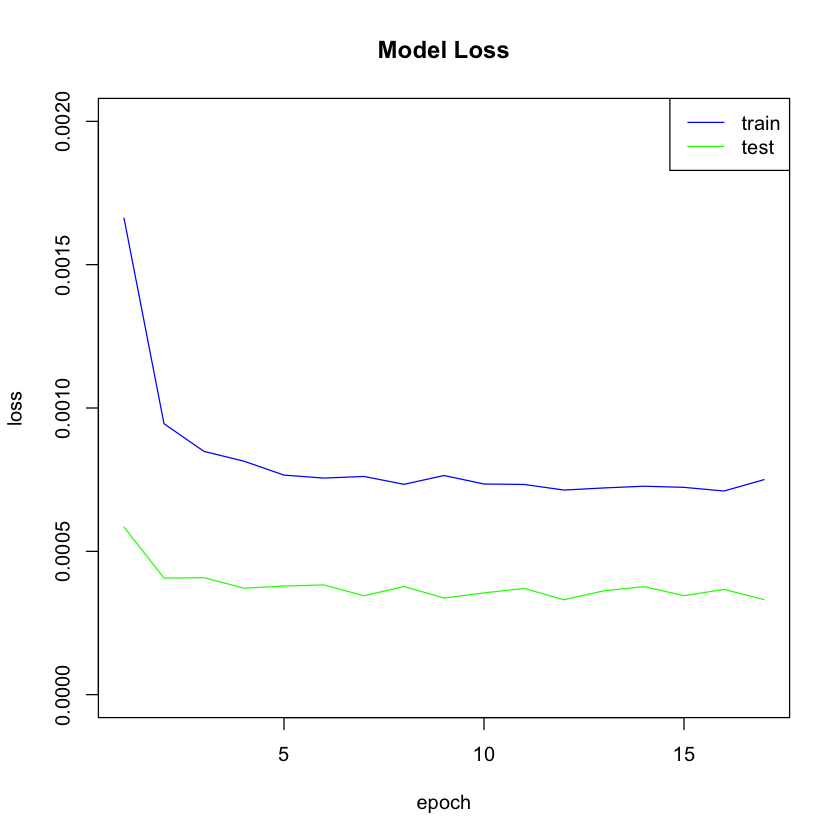

In [30]:
# Plot the model loss of the training & validation data 
plot(history$metrics$loss, main="Model Loss", xlab = "epoch", ylab="loss", col="blue", type="l", 
     ylim = c(0.,0.002), ylog=TRUE)
lines(history$metrics$val_loss, col="green")
legend("topright", c("train","test"), col=c("blue", "green"), lty=c(1,1))

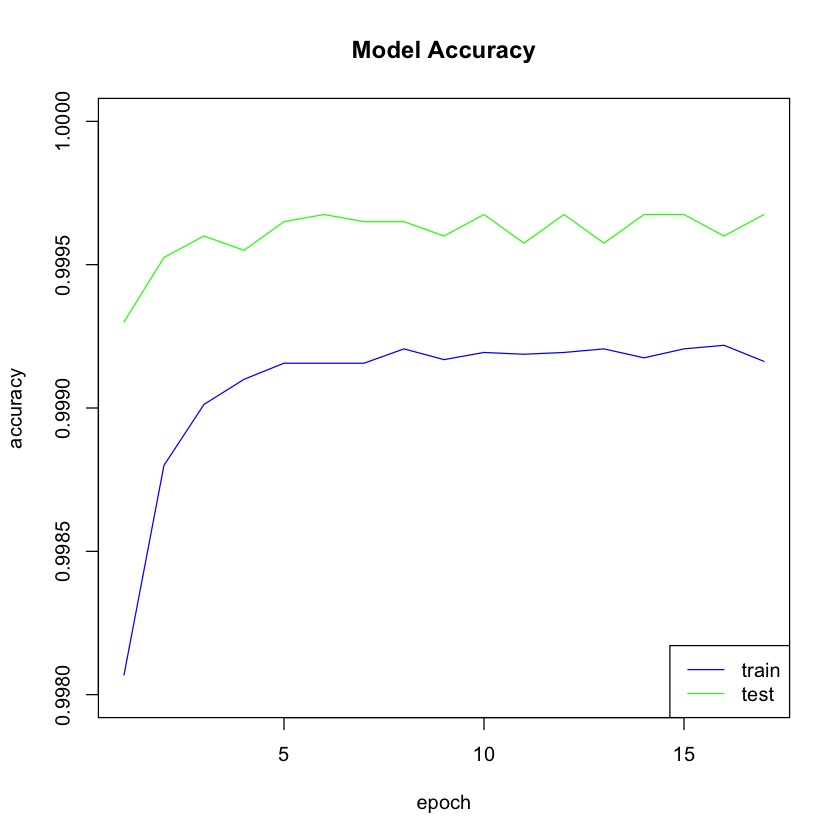

In [32]:
# Plot the model accuracy of the training & validation data 
plot(history$metrics$acc, main="Model Accuracy", xlab = "epoch", ylab="accuracy", col="blue", type="l", 
     ylim = c(0.998,1.))
lines(history$metrics$val_acc, col="green")
legend("bottomright", c("train","test"), col=c("blue", "green"), lty=c(1,1))

In [33]:
# Predict the classes for the test data
classes <- model %>% predict_classes(x_test, batch_size = 128)

# Confusion matrix
table(y_test, classes)

      classes
y_test     0     1
     0 84698     2
     1    29    78

After training we can get the final loss for the test set by using the evaluate() fucntion.

In [34]:
# Evaluate the model on test data and labels
score <- evaluate(model, x = x_test, y = y_test)

# Print the score (loss and accuracy)
print(score)

$loss
[1] 0.000402097

$acc
[1] 0.9996345



### Saving, loading or exporting the Model

In [35]:
# SSaving/loading only a model’s architecture (not its weights or its training configuration)
save_model_hdf5(model, 'my_model.h5')
model <- load_model_hdf5('my_model.h5')
print("Saved model to disk")

[1] "Saved model to disk"


In [42]:
# Additionally, Saving/loading only a model’s weights
#save_model_weights_hdf5(model,filepath="my_model_weights.h5")
#model %>% load_model_weights_hdf5('my_model_weights.h5')

In [43]:
# Export the model configuration to JSON or YAML and later load
#json_string <- model_to_json(model)
#yaml_string <- model_to_yaml(model))

# build a fresh model from this data
#model <- model_from_json(json_string)
#model <- model_from_yaml(yaml_string)

In [36]:
pred_train <- predict(model, x_train)
mse_train <- apply((y_train - pred_train)^2, 1, sum)
head(mse_train)

[1] 4.670468e-07 3.613590e-07 3.631079e-07 1.091123e-09 2.175874e-06
[6] 2.490541e-08

In [37]:
pred_test <- predict(model, x_test)
mse_test <- apply((y_test - pred_test)^2, 1, sum)
head(mse_train)

[1] 4.670468e-07 3.613590e-07 3.631079e-07 1.091123e-09 2.175874e-06
[6] 2.490541e-08

In [38]:
# AUC of ROC for training set
auc(y_train, mse_train)

Warning message in roc.default(response, predictor, auc = TRUE, ...):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”

Area under the curve: 0.9997

In [39]:
# AUC of ROC for testing set
auc(y_test, mse_test)

Warning message in roc.default(response, predictor, auc = TRUE, ...):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”

Area under the curve: 0.9998

Warning message in roc.default(y_test, mse_test, direction = "<"):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”

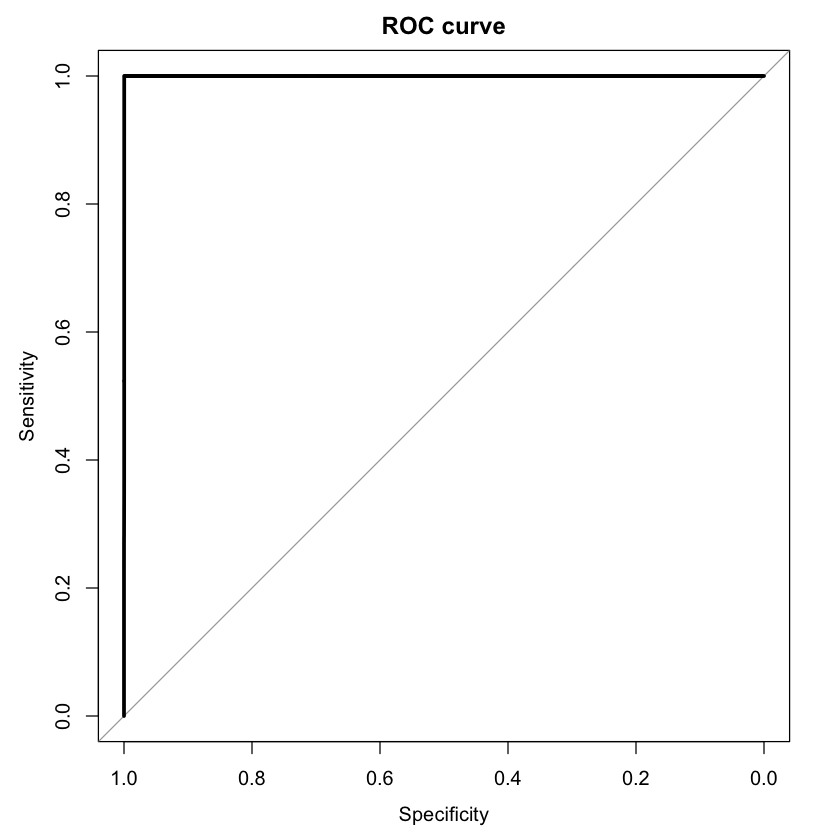

In [40]:
# Plot ROC curve for the test dataset
plot(roc(y_test, mse_test, direction="<"),
     col="black", lwd=3, main="ROC curve")

## Tuning the model with CloudML

We may be able to get better results by tuning our model hyperparameters. We can tune, for example, the normalization function, the learning rate, the activation functions and the size of hidden layers. CloudML uses Bayesian optimization to tune hyperparameters of models.

### Bayesian optimization in Cloud Machine Learning Engine
At Google, in order to implement hyperparameter tuning we use an algorithm called Gaussian process bandits, which is a form of Bayesian optimization. We want to select hyperparameters that give the best performance. Cloud ML Engine offers hyperparameter tuning to help you maximize your model's predictive accuracy. 

Many optimization settings, like the one above, assume that the objective function f(x) )(i.e., performance as a function of hyperparameter values) has a known mathematical form, is convex or is cheap to evaluate. But the above characteristics do not apply to the problem of finding hyperparameters where the function is unknown and expensive to evaluate. This is where Bayesian optimization comes into play.

Bayesian optimization is an extremely powerful technique when the mathematical form of the function is unknown or expensive to compute. The main idea behind it is to compute a posterior distribution over the objective function based on the data (using the famous Bayes theorem), and then select good points to try with respect to this distribution.

### Gaussian processes

To use Bayesian optimization, we need a way to flexibly model distributions over objective functions. This is a bit trickier than modeling a distribution over, say, real numbers, since we’ll need one such distribution to represent our beliefs about f(x) for each x. If x contains continuous hyperparameters, there will be infinitely many x for which we must model f(x), i.e., construct a distribution for it. For this problem, Gaussian processes are a particularly elegant technique. In effect, they generalize multidimensional Gaussian distributions, and versions exist that are flexible enough to model any objective function. 

#### Exploration-exploitation tradeoff

Once we have a model for the objective function, we need to select a good point to try. This creates an exploration-exploitation tradeoff similar to one you face when selecting a restaurant: Do you eat at your usual place (which is reliably good), or take a risk and try the new one (which might be great, or might be terrible)?

The above probabilistic distribution says that after conditioning on the data you have, the predicted value y for a test point x is distributed as a Gaussian. And this Gaussian has two statistics mean and variance. Now, in order to trade off exploration-exploitation we need to choose the next point balancing where mean is high (exploitation) and where the variance is high (exploration).

Acquisition function

To encode the tradeoff between exploration and exploitation, we can define an acquisition function that provides a single measure of how useful it would be to try any given point. We can then repeatedly find the point that maximizes this acquisition function and try it next. Example of acquisition functions are Upper confidence bound, Probability of improvement, and Expected Improvement.

The algorithm which Cloud ML Engine uses for acquisition function is an implementation in Google Vizier called "$\bf{Expected\;Improvement}$". It measures the expected increase in the maximum objective value seen over all experiments, given the next point we pick. In contrast, MPI only takes into account the probability of improvement and not the magnitude of improvement for the next point. 

The objective function were drawn from our posterior distribution, then EI (x) measures the expected increase in the best objective we have found during entire tuning run if we select x and then stop.

Source:
- https://cloud.google.com/blog/big-data/2017/08/hyperparameter-tuning-in-cloud-machine-learning-engine-using-bayesian-optimization

- https://tensorflow.rstudio.com/tools/training_flags.html

In [41]:
library(cloudml)

Loading required package: tfruns


In [42]:
# Flats to allow hyper-paramter tuning in Google's CloudML Engine
FLAGS <- flags(
  flag_string("normalization", "minmax", "One of minmax, zscore"),
  flag_string("activation", "relu", "One of relu, selu, tanh, sigmoid"),
  flag_numeric("learning_rate", 0.001, "Optimizer Learning Rate"),
  flag_integer("hidden_size", 15, "The hidden layer size")
)

We then used the FLAGS variable inside the script to drive the hyperparameters of the model, for example:

In [43]:
model %>% compile(
    optimizer = optimizer_adam(lr = FLAGS$learning_rate), 
    loss = 'mean_squared_error', 
    metrics = c('acc')
    #metrics = 'acc'
)

We also created a tuning.yml file describing how hyperparameters should be varied during training, as well as what metric we wanted to optimize (in this case it was the validation loss: val_loss).



In [44]:
# Submitting Jobs (master_type = 'standard_gpu')
job <- cloudml_train('train.R', config = 'tuning.yml', master_type = 'standard')

Submitting training job to CloudML...
Job 'cloudml_2018_02_08_231751675' successfully submitted.

View job in the Cloud Console at:
https://console.cloud.google.com/ml/jobs/cloudml_2018_02_08_231751675?project=noted-sandbox-194123

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2018_02_08_231751675&project=noted-sandbox-194123

Check job status with:     job_status("cloudml_2018_02_08_231751675")

Collect job output with:   job_collect("cloudml_2018_02_08_231751675")

After collect, view with:  view_run("runs/cloudml_2018_02_08_231751675")



In [45]:
# reference to the training job which you can use later to check it’s status, collect it’s outpu
job_status(job) # get status of last job

Warning message:
“NAs introduced by coercion”Warning message:
“NAs introduced by coercion”

 $ createTime    : chr "2018-02-08T23:51:40Z"
 $ endTime       : chr "2018-02-09T00:33:33Z"
 $ etag          : chr "2i7HN1EV2Rw="
 $ jobId         : chr "cloudml_2018_02_08_231751675"
 $ startTime     : chr "2018-02-08T23:51:45Z"
 $ state         : chr "SUCCEEDED"
 $ trainingInput :List of 6
  ..$ hyperparameters:List of 5
  .. ..$ goal                   : chr "MINIMIZE"
  .. ..$ hyperparameterMetricTag: chr "val_loss"
  .. ..$ maxParallelTrials      : int 5
  .. ..$ maxTrials              : int 10
  .. ..$ params                 :List of 4
  .. .. ..$ :List of 3
  .. .. .. ..$ categoricalValues: chr [1:2] "zscore" "minmax"
  .. .. .. ..$ parameterName    : chr "normalization"
  .. .. .. ..$ type             : chr "CATEGORICAL"
  .. .. ..$ :List of 3
  .. .. .. ..$ categoricalValues: chr [1:4] "relu" "selu" "tanh" "sigmoid"
  .. .. .. ..$ parameterName    : chr "activation"
  .. .. .. ..$ type             : chr "CATEGORICAL"
  .. .. ..$ :List of 5
  .. .. .. ..$ maxValue     : num 0.1


#### Collecting Job Results

In [46]:
# After the job is finished we can collect the job results with:
job_collect()

# collect jobs executed as part of a hyperparameter tunning run using

Copying gs://noted-sandbox-194123/r-cloudml/runs/cloudml_2018_02_08_231751675/9/model.hdf5...
Copying gs://noted-sandbox-194123/r-cloudml/runs/cloudml_2018_02_08_231751675/9/tfruns.d/properties/end...
Copying gs://noted-sandbox-194123/r-cloudml/runs/cloudml_2018_02_08_231751675/9/tfruns.d/flags.json...
Copying gs://noted-sandbox-194123/r-cloudml/runs/cloudml_2018_02_08_231751675/9/tfruns.d/properties/batch_size...
Copying gs://noted-sandbox-194123/r-cloudml/runs/cloudml_2018_02_08_231751675/9/tfruns.d/properties/completed...
Copying gs://noted-sandbox-194123/r-cloudml/runs/cloudml_2018_02_08_231751675/9/tfruns.d/metrics.json...
Copying gs://noted-sandbox-194123/r-cloudml/runs/cloudml_2018_02_08_231751675/9/tfruns.d/properties/context...
Copying gs://noted-sandbox-194123/r-cloudml/runs/cloudml_2018_02_08_231751675/9/logs/events.out.tfevents.1518135247.cmle-training-master-04e5625885-0-0xcv6...
Copying gs://noted-sandbox-194123/r-cloudml/runs/cloudml_2018_02_08_231751675/9/tfruns.d/prope

In [47]:
# Can determine this directory for the most recent run with:
latest_run()$run_dir

[1] "runs/cloudml_2018_02_08_231751675-09"

In [49]:
# Collecting trials, inspect all of the job trails using
#job_trials("cloudml_2018_02_08_231751675-09") # or trials = "all"

In [50]:
# Can also list all previous runs and their validation losses with:
ls_runs(order = metric_val_loss, decreasing = FALSE)

,run_dir,metric_val_loss,eval_loss,eval_acc,metric_loss,metric_acc,metric_val_acc,flag_normalization,flag_activation,flag_learning_rate,⋯,type,cloudml_console_url,cloudml_created,cloudml_end,cloudml_job,cloudml_log_url,cloudml_master_type,cloudml_ml_units,cloudml_start,cloudml_state
1,runs/cloudml_2018_02_08_231751675-09,0.0000e+00,NA,NA,0.0000e+00,0.9970,0.9973,minmax,sigmoid,0.0098,⋯,training,https://console.cloud.google.com/ml/jobs/cloudml_2018_02_08_231751675?project=noted-sandbox-194123,2018-02-08 23:51:40,2018-02-09 00:33:33,cloudml_2018_02_08_231751675,https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2018_02_08_231751675&project=noted-sandbox-194123,standard,1.12,2018-02-08 23:51:45,SUCCEEDED
2,runs/cloudml_2018_02_08_124559288-06,0.0000e+00,NA,NA,0.0000e+00,0.9971,0.9970,minmax,tanh,0.0017,⋯,training,https://console.cloud.google.com/ml/jobs/cloudml_2018_02_08_124559288?project=noted-sandbox-194123,2018-02-08 12:48:44,2018-02-08 13:32:15,cloudml_2018_02_08_124559288,https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2018_02_08_124559288&project=noted-sandbox-194123,standard,1.33,2018-02-08 12:48:48,SUCCEEDED
3,runs/cloudml_2018_02_08_005546790-05,1.3714e-06,NA,NA,3.4459e-07,NA,NA,minmax,tanh,0.0000,⋯,training,https://console.cloud.google.com/ml/jobs/cloudml_2018_02_08_005546790?project=noted-sandbox-194123,2018-02-08 01:06:27,2018-02-08 02:48:37,cloudml_2018_02_08_005546790,https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2018_02_08_005546790&project=noted-sandbox-194123,standard_gpu,10.82,2018-02-08 01:06:31,SUCCEEDED
5,runs/cloudml_2018_02_07_180307730,1.0960e-01,0.1058,0.9807,5.3700e-02,0.9863,0.9803,NA,NA,NA,⋯,training,https://console.cloud.google.com/ml/jobs/cloudml_2018_02_07_180307730?project=noted-sandbox-194123,2018-02-07 18:03:38,2018-02-07 18:19:07,cloudml_2018_02_07_180307730,https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2018_02_07_180307730&project=noted-sandbox-194123,NA,0.10,2018-02-07 18:04:25,SUCCEEDED
4,runs/cloudml_2018_02_08_002625470,1.1320e-01,0.1028,0.9805,5.2400e-02,0.9861,0.9797,NA,NA,NA,⋯,training,https://console.cloud.google.com/ml/jobs/cloudml_2018_02_08_002625470?project=noted-sandbox-194123,2018-02-08 00:37:55,2018-02-08 00:48:51,cloudml_2018_02_08_002625470,https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2018_02_08_002625470&project=noted-sandbox-194123,NA,0.09,2018-02-08 00:38:41,SUCCEEDED


In [51]:
# You can list all of the runs as a data frame
ls_runs()

run_dir,eval_loss,eval_acc,metric_loss,metric_acc,metric_val_loss,metric_val_acc,flag_normalization,flag_activation,flag_learning_rate,⋯,type,cloudml_console_url,cloudml_created,cloudml_end,cloudml_job,cloudml_log_url,cloudml_master_type,cloudml_ml_units,cloudml_start,cloudml_state
runs/cloudml_2018_02_08_231751675-09,NA,NA,0.0000e+00,0.9970,0.0000e+00,0.9973,minmax,sigmoid,0.0098,⋯,training,https://console.cloud.google.com/ml/jobs/cloudml_2018_02_08_231751675?project=noted-sandbox-194123,2018-02-08 23:51:40,2018-02-09 00:33:33,cloudml_2018_02_08_231751675,https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2018_02_08_231751675&project=noted-sandbox-194123,standard,1.12,2018-02-08 23:51:45,SUCCEEDED
runs/cloudml_2018_02_08_124559288-06,NA,NA,0.0000e+00,0.9971,0.0000e+00,0.9970,minmax,tanh,0.0017,⋯,training,https://console.cloud.google.com/ml/jobs/cloudml_2018_02_08_124559288?project=noted-sandbox-194123,2018-02-08 12:48:44,2018-02-08 13:32:15,cloudml_2018_02_08_124559288,https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2018_02_08_124559288&project=noted-sandbox-194123,standard,1.33,2018-02-08 12:48:48,SUCCEEDED
runs/cloudml_2018_02_08_005546790-05,NA,NA,3.4459e-07,NA,1.3714e-06,NA,minmax,tanh,0.0000,⋯,training,https://console.cloud.google.com/ml/jobs/cloudml_2018_02_08_005546790?project=noted-sandbox-194123,2018-02-08 01:06:27,2018-02-08 02:48:37,cloudml_2018_02_08_005546790,https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2018_02_08_005546790&project=noted-sandbox-194123,standard_gpu,10.82,2018-02-08 01:06:31,SUCCEEDED
runs/cloudml_2018_02_08_002625470,0.1028,0.9805,5.2400e-02,0.9861,1.1320e-01,0.9797,NA,NA,NA,⋯,training,https://console.cloud.google.com/ml/jobs/cloudml_2018_02_08_002625470?project=noted-sandbox-194123,2018-02-08 00:37:55,2018-02-08 00:48:51,cloudml_2018_02_08_002625470,https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2018_02_08_002625470&project=noted-sandbox-194123,NA,0.09,2018-02-08 00:38:41,SUCCEEDED
runs/cloudml_2018_02_07_180307730,0.1058,0.9807,5.3700e-02,0.9863,1.0960e-01,0.9803,NA,NA,NA,⋯,training,https://console.cloud.google.com/ml/jobs/cloudml_2018_02_07_180307730?project=noted-sandbox-194123,2018-02-07 18:03:38,2018-02-07 18:19:07,cloudml_2018_02_07_180307730,https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2018_02_07_180307730&project=noted-sandbox-194123,NA,0.10,2018-02-07 18:04:25,SUCCEEDED


In [53]:
# view the latest run
#view_run()

# view a specific run
view_run("runs/cloudml_2018_02_08_231751675-09")

In [74]:
# https://tensorflow.rstudio.com/tools/cloudml/articles/tuning.html
#summary <- tf$Summary()
#iteration_number = 40
#summary$value$add(tag = "acc", simple_value = 0.95)
#summary_writer$add_summary(summary, iteration_number)

In our case the job downloaded from CloudML was saved to runs/cloudml_2018_01_23_221244595-03/, so the saved model file is available at runs/cloudml_2018_01_23_221244595-03/model.hdf5. We can now use our tuned model to make predictions.

$\bf{Note}$: that instead of literal values for the various parameters we want to vary we now reference members of the FLAGS list returned from the flags() function.

The cloudml package takes care of uploading the dataset and installing any R package dependencies required to run the script on CloudML.

## Making predictions

Now that we trained and tuned our model we are ready to generate predictions with our autoencoder. We are interested in the MSE for each observation and we expect that observations of fraudulent transactions will have higher MSE’s.

In [145]:
# First, let’s load our model.
#model <- load_model_hdf5("/Users/DesyFellow/Desktop/CloudML/runs/cloudml_2018_02_08_124559288-06/model.hdf5", compile = FALSE)
#model <- load_model_hdf5("runs/cloudml_2018_02_08_124559288-06/model.hdf5")

Now let’s calculate the MSE for the training and test set observations.

In [54]:
pred_train <- predict(model, x_train)
mse_train <- apply((y_train - pred_train)^2, 1, sum)
head(mse_train)

[1] 4.670468e-07 3.613590e-07 3.631079e-07 1.091123e-09 2.175874e-06
[6] 2.490541e-08

In [55]:
pred_test <- predict(model, x_test)
mse_test <- apply((y_test - pred_test)^2, 1, sum)
head(mse_train)

[1] 4.670468e-07 3.613590e-07 3.631079e-07 1.091123e-09 2.175874e-06
[6] 2.490541e-08

A good measure of model performance in highly unbalanced datasets is the Area Under the ROC Curve (AUC). AUC has a nice interpretation for this problem, it’s the probability that a fraudulent transaction will have higher MSE then a normal one. We can calculate this using the Metrics package, which implements a wide variety of common machine learning model performance metrics.

In [56]:
auc(y_train, mse_train)

Warning message in roc.default(response, predictor, auc = TRUE, ...):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”

Area under the curve: 0.9997

In [57]:
auc(y_test, mse_test)

Warning message in roc.default(response, predictor, auc = TRUE, ...):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”

Area under the curve: 0.9998

To use the model in practice for making predictions we need to find a threshold 
k for the MSE, then if MSE>k we consider that transaction a fraud (otherwise we consider it normal). To define this value it’s useful to look at precision and recall while varying the threshold 
k.

In [136]:
possible_k <- seq(0, 0.5, length.out = 100)

precision <- sapply(possible_k, function(k) {
  predicted_class <- as.numeric(mse_test > k)
  sum(predicted_class == 1 & y_test == 1)/sum(predicted_class)
})

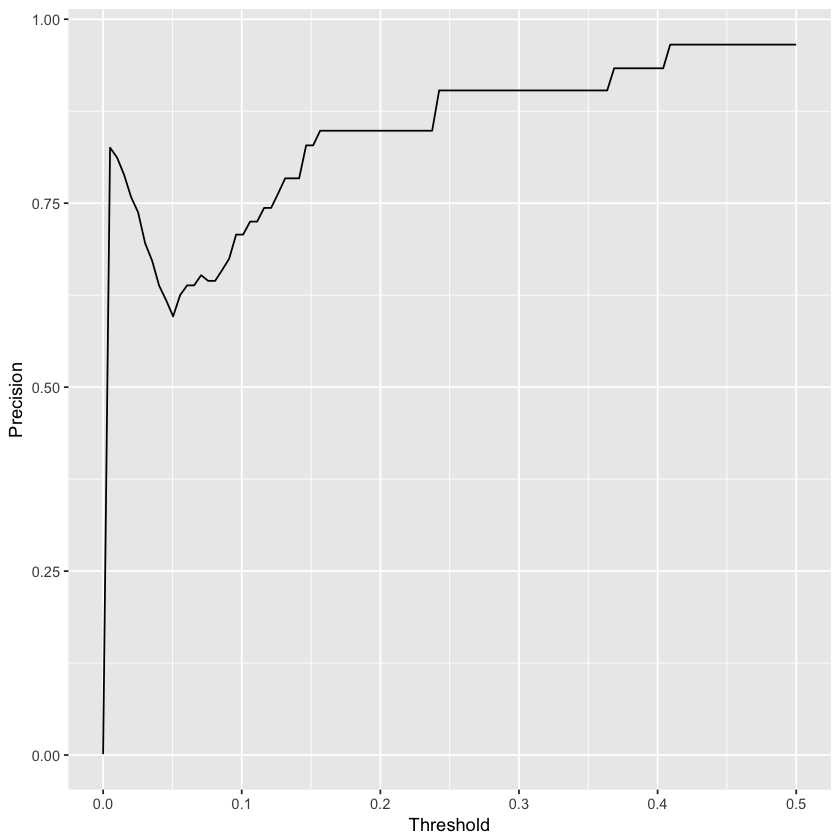

In [137]:
qplot(possible_k, precision, geom = "line") + labs(x = "Threshold", y = "Precision")

In [138]:
recall <- sapply(possible_k, function(k) {
  predicted_class <- as.numeric(mse_test > k)
  sum(predicted_class == 1 & y_test == 1)/sum(y_test)
})

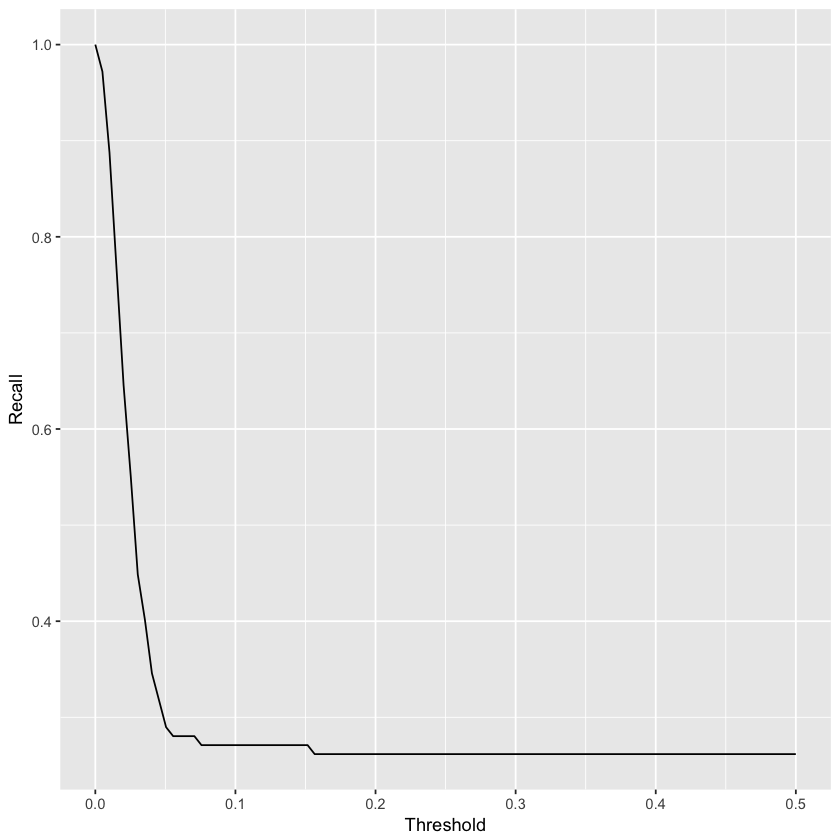

In [139]:
qplot(possible_k, recall, geom = "line") + labs(x = "Threshold", y = "Recall")

A good starting point would be to choose the threshold with maximum precision but we could also base our decision on how much money we might lose from fraudulent transactions.

Suppose each manual verification of fraud costs us $1 but if we don’t verify a transaction and it’s a fraud we will lose this transaction amount. Let’s find for each threshold value how much money we would lose.

In [140]:
cost_per_verification <- 1

lost_money <- sapply(possible_k, function(k) {
  predicted_class <- as.numeric(mse_test > k)
  sum(cost_per_verification * predicted_class + (predicted_class == 0) * y_test * df_test$Amount) 
})

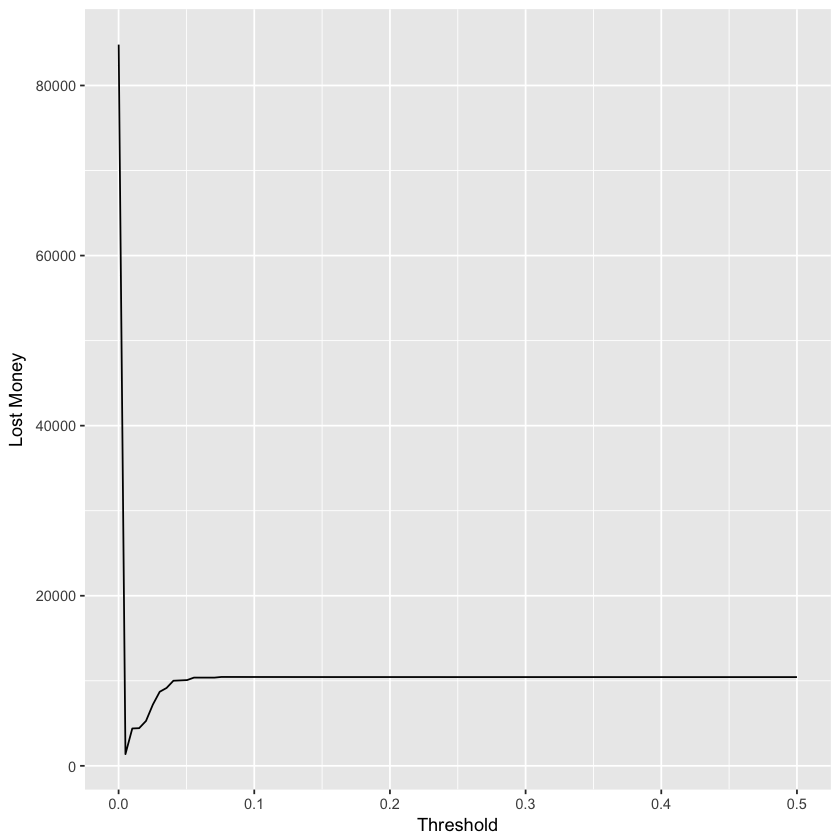

In [141]:
qplot(possible_k, lost_money, geom = "line") + labs(x = "Threshold", y = "Lost Money")

We can find the best threshold in this case with:

In [142]:
possible_k[which.min(lost_money)]

[1] 0.005050505

## Summary

If we needed to manually verify all frauds, it would cost us approx. \$13,000. Using our model we can reduce this to approx. \$2,500.